In [1]:
"""         W E A T H E R  C A T E G O R I S A T I O N
                   ... vytvoril Lukas Patrnciak
                   AIS ID: 92320
                   mail: xpatrnciak@stuba.sk

Lepsie pouzit One-Hot Encoding spolu so StandardScalerom
"""

'         W E A T H E R  C A T E G O R I S A T I O N\n                   ... vytvoril Lukas Patrnciak\n                   AIS ID: 92320\n                   mail: xpatrnciak@stuba.sk\n'

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

In [ ]:
def median_replace(data, column):
    data[column] = pd.to_numeric(data[column], errors='coerce')
    median_value = data[column].median()
    data[column] = data[column].fillna(median_value)

    return data

def outliers(data):
    cleaned_data = data.copy()
    
    for col in cleaned_data.select_dtypes(include=[np.number]).columns:
        Q1 = cleaned_data[col].quantile(0.25)
        Q3 = cleaned_data[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        cleaned_data = cleaned_data[(cleaned_data[col] >= lower_bound) & (cleaned_data[col] <= upper_bound)]
    
    return cleaned_data

def generate_correlation_matrix(data, title_text):
    correlation_matrix = data.corr(numeric_only=True)

    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
    plt.title(title_text)
    
    plt.show()

def train_model(split_ratio1, split_ratio2, X, Y, iter_count, rand_state):
    values = []

    Xtrain, Xtemp, Ytrain, Ytemp = train_test_split(X, Y, test_size=split_ratio1, random_state=rand_state)
    Xval, Xtest, Yval, Ytest = train_test_split(Xtemp, Ytemp, test_size=split_ratio2, random_state=rand_state)
    
    scaler = MinMaxScaler()

    Xtrain = scaler.fit_transform(Xtrain)
    Xtest = scaler.transform(Xtest)
    Xval = scaler.transform(Xval)

    model = LogisticRegression(max_iter=iter_count)
    model.fit(Xtrain, Ytrain)

    Ypred = model.predict(Xtest)

    accuracy = accuracy_score(Ytest, Ypred)
    conf_matrix = confusion_matrix(Ytest, Ypred)
    
    values.append(model)
    values.append(accuracy)
    values.append(conf_matrix)
    values.append(Xtrain)
    values.append(Xtest)
    values.append(Xval)
    values.append(Ytrain)
    values.append(Ytest)
    values.append(Yval)
        
    return values

def generate_confusion_matrix(conf_matrix, title_text):
    plt.figure(figsize=(7,6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Oranges')
    plt.title(title_text)
    plt.xlabel("Predicted Data")
    plt.ylabel("Real Data")
    
    plt.show()

def build_model(learning_rate, first_layer_neurons, second_layer_neurons, first_dropout_rate, second_dropout_rate):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))
    
    model.add(Dense(first_layer_neurons, activation='relu'))
    model.add(Dropout(first_dropout_rate))
    
    model.add(Dense(second_layer_neurons, activation='relu'))
    model.add(Dropout(second_dropout_rate))
    
    model.add(Dense(weather_data['Weather Type'].nunique(), activation='softmax'))
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
    
    return model

def generate_plots(history):
    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training Loss and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history['sparse_categorical_accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
    plt.title('Training Accuracy and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

def generate_accuracy(model):
    Y_train_pred = model.predict(X_train)
    Y_test_pred = model.predict(X_test)

    Y_train_pred = np.argmax(Y_train_pred, axis=1)
    Y_test_pred = np.argmax(Y_test_pred, axis=1)

    train_accuracy = accuracy_score(Y_train, Y_train_pred)
    test_accuracy = accuracy_score(Y_test, Y_test_pred)

    print(f'\nTrenovacia uspesnost: {train_accuracy}')
    print(f'Testovacia uspesnost: {test_accuracy}')

    train_cm = confusion_matrix(Y_train, Y_train_pred)
    test_cm = confusion_matrix(Y_test, Y_test_pred)

    generate_confusion_matrix(train_cm, "Confusion Matrix - Train Accuracy")
    generate_confusion_matrix(test_cm, "Confusion Matrix - Test Accuracy")

In [4]:
file_path = "weather_data.csv"
weather_data = pd.read_csv(file_path)
stats = weather_data.describe()
null_values = weather_data.isnull().sum().sum()
duplicates = weather_data.duplicated().sum()
samples = weather_data.shape[0]

print("Pocet chybajucich hodnot:", null_values, "\nPocet duplicit:", duplicates, "\nPocet vzoriek:", samples, "\n\n", weather_data.head(5), "\n\n", stats)

Pocet chybajucich hodnot: 12169 
Pocet duplicit: 13 
Pocet vzoriek: 13214 

    Temperature  Humidity  Wind Speed  Precipitation (%)    Cloud Cover  \
0         14.0      73.0         9.5               82.0  partly cloudy   
1         39.0      96.0         8.5               71.0  partly cloudy   
2         30.0      64.0         7.0               16.0          clear   
3         38.0      83.0         1.5               82.0          clear   
4         27.0      74.0        17.0               66.0       overcast   

   Atmospheric Pressure UV Index  Season  Visibility (km)  Location  \
0               1010.82      2.0  Winter              3.5    inland   
1               1011.43      7.0  Spring             10.0    inland   
2               1018.72      5.0  Spring              5.5  mountain   
3               1026.25      7.0  Spring              1.0   coastal   
4                990.67      1.0  Winter              2.5  mountain   

  Weather Type  Irradiance  
0        Rainy        

In [5]:
missing_data = weather_data.isnull().mean() * 100 
columns_to_drop = missing_data[missing_data > 25].index
weather_data = weather_data.drop(columns=columns_to_drop)

strings = ['Cloud Cover', 'Season', 'Location', 'Weather Type', 'Irradiance']
numericals = ['Temperature', 'Humidity', 'Wind Speed', 'Precipitation (%)', 'Atmospheric Pressure', 'UV Index', 'Visibility (km)']

string_set = [col for col in strings if col not in columns_to_drop]
numerical_set = [col for col in numericals if col not in columns_to_drop]

for i in numerical_set:
    weather_data = median_replace(weather_data, i)

weather_data = outliers(weather_data)
weather_data = weather_data.drop_duplicates()
weather_data = weather_data.dropna()

weather_data = weather_data[(weather_data['Temperature'] >= -25) &  (weather_data['Temperature'] <= 109)]
weather_data = weather_data[(weather_data['Humidity'] >= 20) & (weather_data['Humidity'] <= 109)]
weather_data = weather_data[(weather_data['Wind Speed'] >= 0) &  (weather_data['Wind Speed'] <= 48.5)]
weather_data = weather_data[(weather_data['Precipitation (%)'] >= 0) & (weather_data['Precipitation (%)'] <= 109)]
weather_data = weather_data[(weather_data['Atmospheric Pressure'] >= 984) & (weather_data['Atmospheric Pressure'] <= 1067)]
weather_data = weather_data[(weather_data['UV Index'] >= 0) & (weather_data['UV Index'] <= 14)]
weather_data = weather_data[(weather_data['Visibility (km)'] >= 0) & (weather_data['Visibility (km)'] <= 20)]
#weather_data = weather_data[(weather_data['Irradiance'] >= 200) & (weather_data['Irradiance'] <= 800)]

weather_data = weather_data[weather_data['Location'].isin(['inland', 'mountain', 'coastal'])]
weather_data = weather_data[weather_data['Cloud Cover'].isin(['partly cloudy', 'clear', 'overcast', 'cloudy'])]
weather_data = weather_data[weather_data['Season'].isin(['Winter', 'Spring', 'Summer', 'Autumn'])]
weather_data = weather_data[weather_data['Weather Type'].isin(['Sunny', 'Cloudy', 'Rainy', 'Snowy'])] 

null_values = weather_data.isnull().sum().sum()
duplicates = weather_data.duplicated().sum()
samples = weather_data.shape[0]
stats = weather_data.describe()

string_columns = weather_data.select_dtypes(exclude=['number']).columns.tolist()
numerical_columns = weather_data.select_dtypes(exclude=['object']).columns.tolist()

print("Pocet chybajucich hodnot:", null_values, "\nPocet duplicit:", duplicates, "\nPocet vzoriek:", samples, "\nStlpce, v ktorych sa nachadza string:", string_columns, "\nStlpce, v ktorych sa nachadzaju cisla: ", numerical_columns, "\n\n", weather_data.head(5), "\n\n", stats)

Pocet chybajucich hodnot: 0 
Pocet duplicit: 0 
Pocet vzoriek: 10970 
Stlpce, v ktorych sa nachadza string: ['Cloud Cover', 'Season', 'Location', 'Weather Type'] 
Stlpce, v ktorych sa nachadzaju cisla:  ['Temperature', 'Humidity', 'Wind Speed', 'Precipitation (%)', 'Atmospheric Pressure', 'UV Index', 'Visibility (km)'] 

    Temperature  Humidity  Wind Speed  Precipitation (%)    Cloud Cover  \
0         14.0      73.0         9.5               82.0  partly cloudy   
1         39.0      96.0         8.5               71.0  partly cloudy   
2         30.0      64.0         7.0               16.0          clear   
3         38.0      83.0         1.5               82.0          clear   
4         27.0      74.0        17.0               66.0       overcast   

   Atmospheric Pressure  UV Index  Season  Visibility (km)  Location  \
0               1010.82       2.0  Winter              3.5    inland   
1               1011.43       7.0  Spring             10.0    inland   
2              

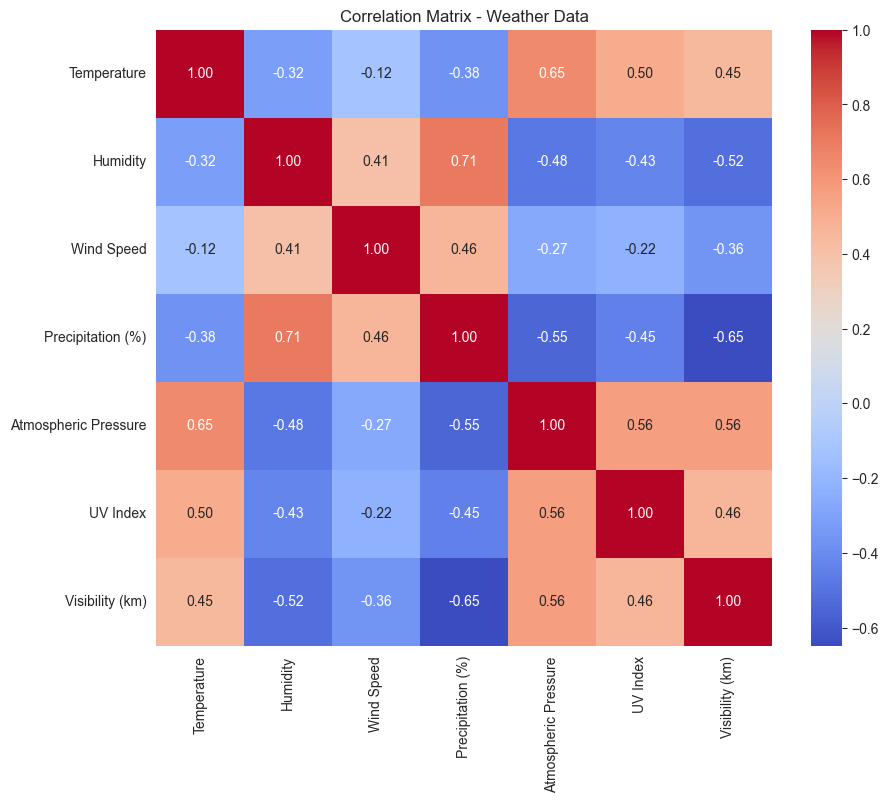

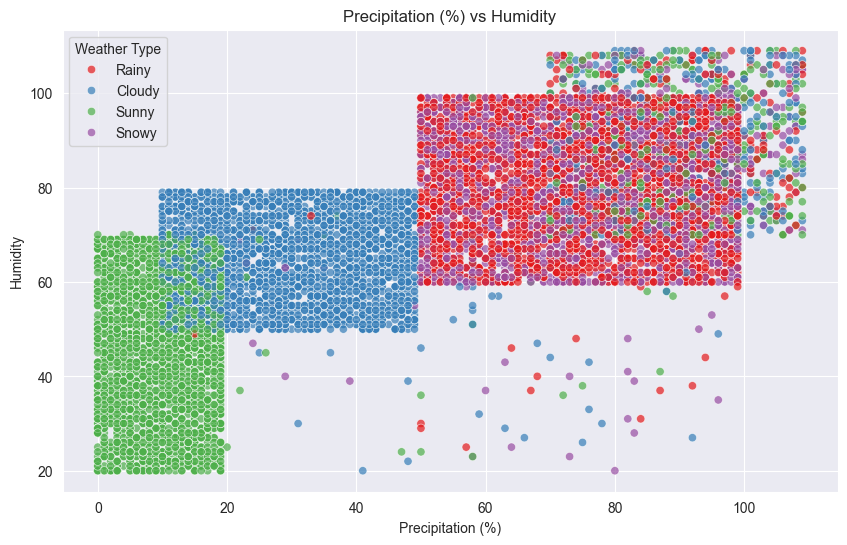

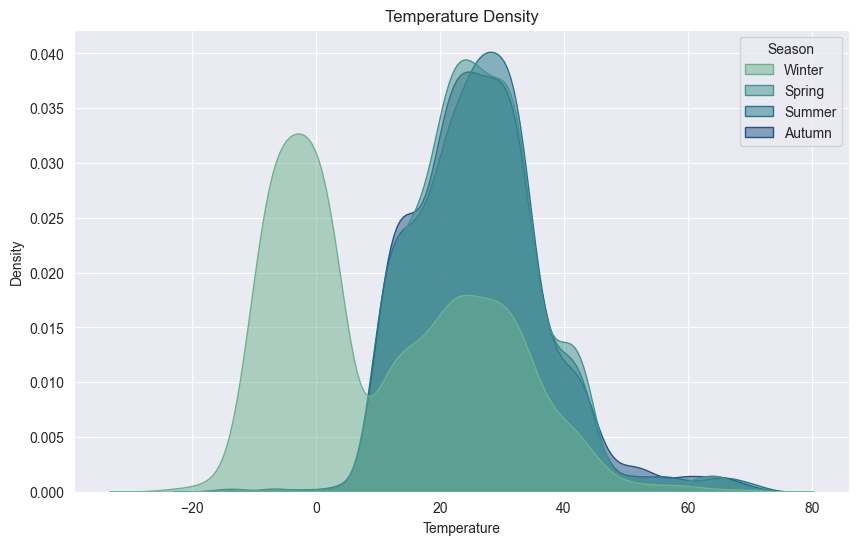

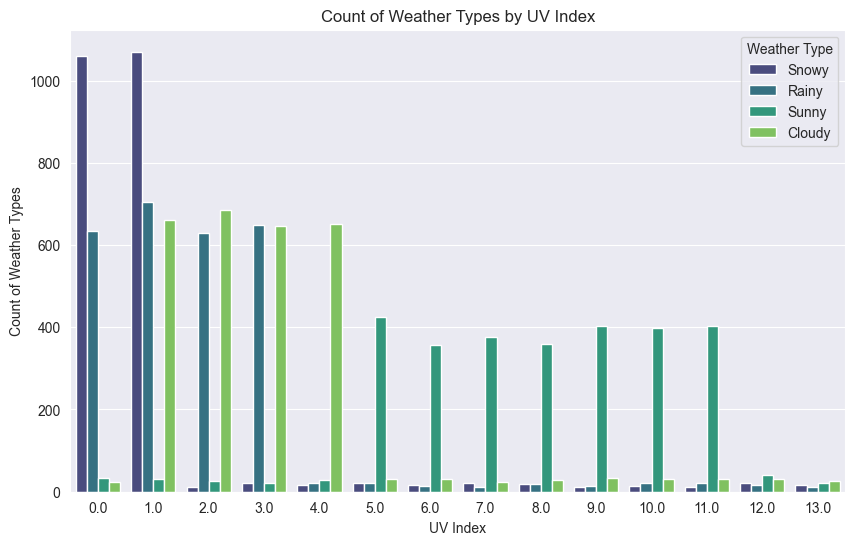

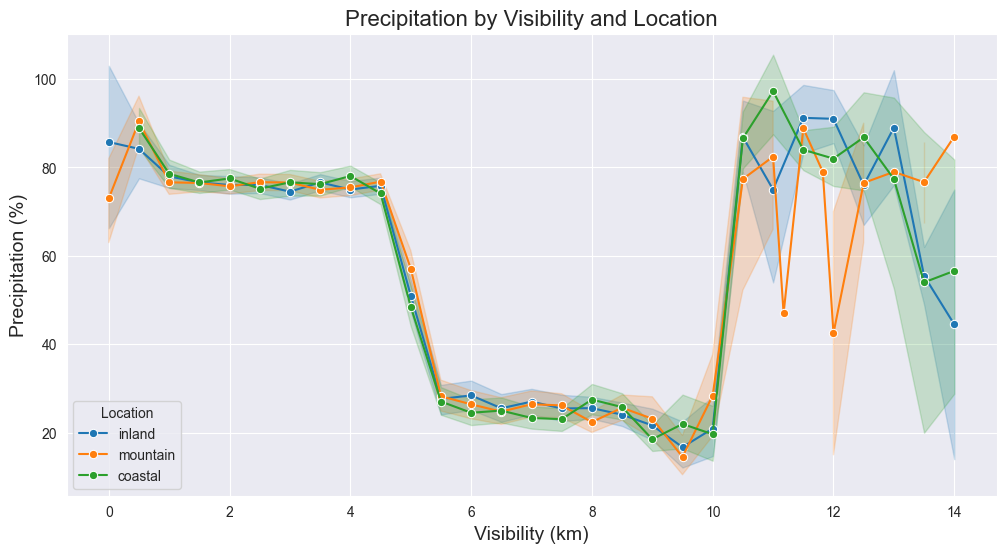

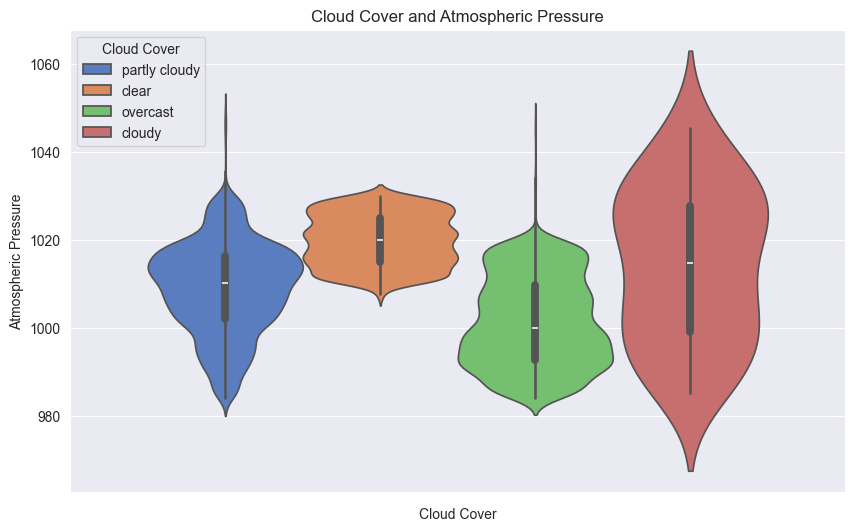

In [6]:
generate_correlation_matrix(weather_data, title_text='Correlation Matrix - Weather Data')

# Pravdepodobnost zrazok a vlhkost
plt.figure(figsize=(10, 6))
sns.scatterplot(data=weather_data, x='Precipitation (%)', y='Humidity', hue='Weather Type', palette='Set1', alpha=0.7)
plt.title('Precipitation (%) vs Humidity')
plt.xlabel('Precipitation (%)')
plt.ylabel('Humidity')
plt.legend(title='Weather Type')

# Teplotna hustota vzhladom na rocne obdobie
plt.figure(figsize=(10, 6))
sns.kdeplot(data=weather_data, x='Temperature', hue='Season', fill=True, common_norm=False, palette='crest', alpha=0.5)
plt.title('Temperature Density')
plt.xlabel('Temperature')
plt.ylabel('Density')

# Pocet typov pocasia podla UV indexu
plt.figure(figsize=(10, 6))
sns.countplot(data=weather_data, x='UV Index', hue='Weather Type', palette='viridis')
plt.title('Count of Weather Types by UV Index')
plt.xlabel('UV Index')
plt.ylabel('Count of Weather Types')
plt.legend(title='Weather Type')

# Zrazky podla viditelnosti a polohy
plt.figure(figsize=(12, 6))
sns.lineplot(data=weather_data, x='Visibility (km)', y='Precipitation (%)', hue='Location', marker='o')
plt.title('Precipitation by Visibility and Location', fontsize=16)
plt.xlabel('Visibility (km)', fontsize=14)
plt.ylabel('Precipitation (%)', fontsize=14)
plt.legend(title='Location')

# Oblacnost a atmosgericky tlak
plt.figure(figsize=(10, 6))
sns.violinplot(hue='Cloud Cover', y='Atmospheric Pressure', data=weather_data, palette='muted')
plt.title('Cloud Cover and Atmospheric Pressure')
plt.xlabel('Cloud Cover')
plt.ylabel('Atmospheric Pressure')

plt.show()

In [7]:
encoder = LabelEncoder()

for str_column in string_columns:
    weather_data[str_column] = encoder.fit_transform(weather_data[str_column])

print("Nasledovne stlpce v datasete boli uspesne zakodovanie Label Encoderom: ", string_columns, "\n\n", weather_data)

Nasledovne stlpce v datasete boli uspesne zakodovanie Label Encoderom:  ['Cloud Cover', 'Season', 'Location', 'Weather Type'] 

        Temperature  Humidity  Wind Speed  Precipitation (%)  Cloud Cover  \
0             14.0      73.0         9.5               82.0            3   
1             39.0      96.0         8.5               71.0            3   
2             30.0      64.0         7.0               16.0            0   
3             38.0      83.0         1.5               82.0            0   
4             27.0      74.0        17.0               66.0            2   
...            ...       ...         ...                ...          ...   
13194         29.0      62.0        13.0               17.0            2   
13195         10.0      74.0        14.5               71.0            2   
13197         30.0      77.0         5.5               28.0            2   
13198          3.0      76.0        10.0               94.0            2   
13199         -5.0      38.0       

   Deliaci pomer 1  Deliaci pomer 2  Uspesnost
0              0.3              0.4   0.933941
1              0.3              0.1   0.936364
2              0.2              0.4   0.943052
3              0.1              0.2   0.963636 


Najlepsi experiment je experiment cislo 3 s deliacimi pomermi 10.0 % a  20.0 %


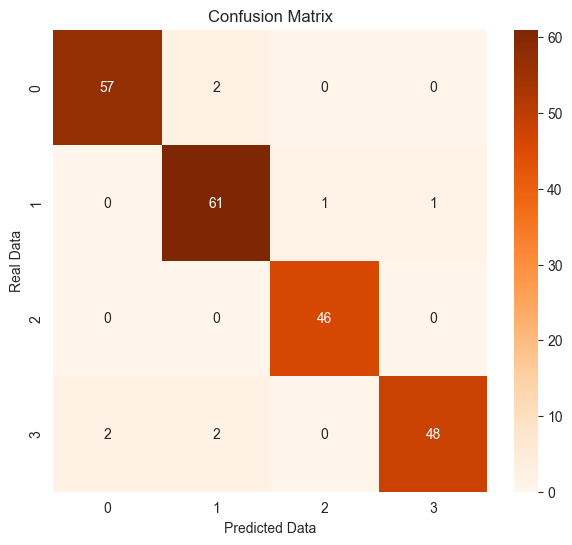

In [8]:
Xset = weather_data.drop(columns=['Weather Type'])
Yset = weather_data['Weather Type']
split_ratios1 = [0.3, 0.3, 0.2, 0.1]
split_ratios2 = [0.4, 0.1, 0.4, 0.2]
results1 = []
best_ratio = 0

for i in range(4):
    acc = train_model(split_ratios1[i], split_ratios2[i], Xset, Yset, 200, 42)[1]
    results1.append({
        'Deliaci pomer 1': split_ratios1[i],
        'Deliaci pomer 2': split_ratios2[i],
        'Uspesnost': acc
    })


results1 = pd.DataFrame(results1, columns=['Deliaci pomer 1', 'Deliaci pomer 2', 'Uspesnost'])
print(results1, "\n\n")

max_acc_row = results1.loc[results1['Uspesnost'].idxmax()] 
max_ratio_pomer_1 = max_acc_row['Deliaci pomer 1']
max_ratio_pomer_2 = max_acc_row['Deliaci pomer 2']

model1 = train_model(max_ratio_pomer_1, max_ratio_pomer_2, Xset, Yset, 200, 42)[0]
accuracy1 = train_model(max_ratio_pomer_1, max_ratio_pomer_2, Xset, Yset, 200, 42)[1]
confus_matrix = train_model(max_ratio_pomer_1, max_ratio_pomer_2, Xset, Yset, 200, 42)[2]
X_train = train_model(max_ratio_pomer_1, max_ratio_pomer_2, Xset, Yset, 200, 42)[3]
X_test = train_model(max_ratio_pomer_1, max_ratio_pomer_2, Xset, Yset, 200, 42)[4]
X_val = train_model(max_ratio_pomer_1, max_ratio_pomer_2, Xset, Yset, 200, 42)[5]
Y_train = train_model(max_ratio_pomer_1, max_ratio_pomer_2, Xset, Yset, 200, 42)[6]
Y_test = train_model(max_ratio_pomer_1, max_ratio_pomer_2, Xset, Yset, 200, 42)[7]
Y_val = train_model(max_ratio_pomer_1, max_ratio_pomer_2, Xset, Yset, 200, 42)[8]

print("Najlepsi experiment je experiment cislo", results1['Uspesnost'].idxmax(), "s deliacimi pomermi", max_ratio_pomer_1*100, "% a ",  max_ratio_pomer_2*100, "%")
generate_confusion_matrix(confus_matrix, title_text='Confusion Matrix')

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1768 - sparse_categorical_accuracy: 0.9879 

Treningova a validacna strata:  0.20303788781166077 
Treningova a validacna uspesnost:  0.9818181991577148


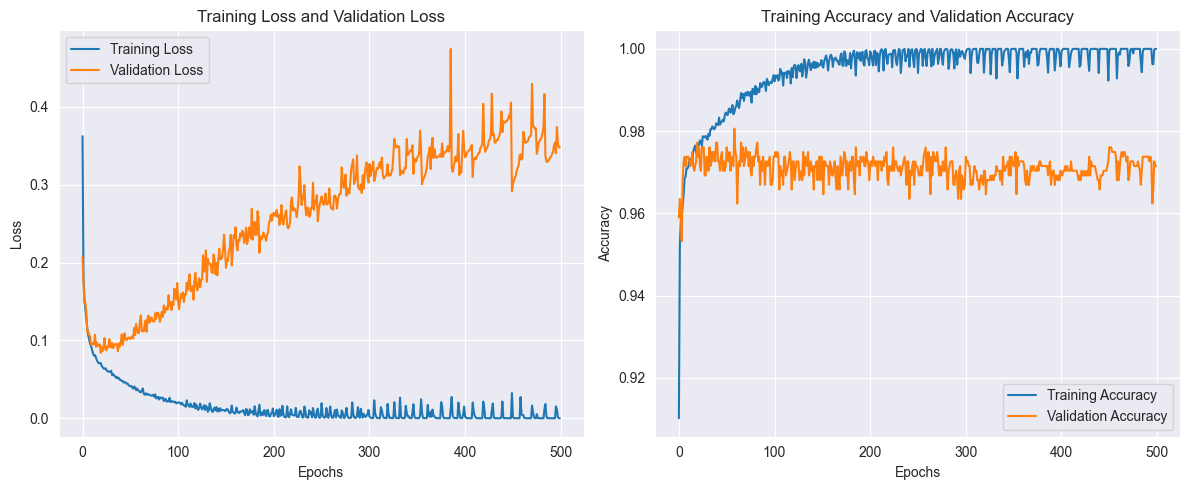

309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

Trenovacia uspesnost: 1.0
Testovacia uspesnost: 0.9818181818181818


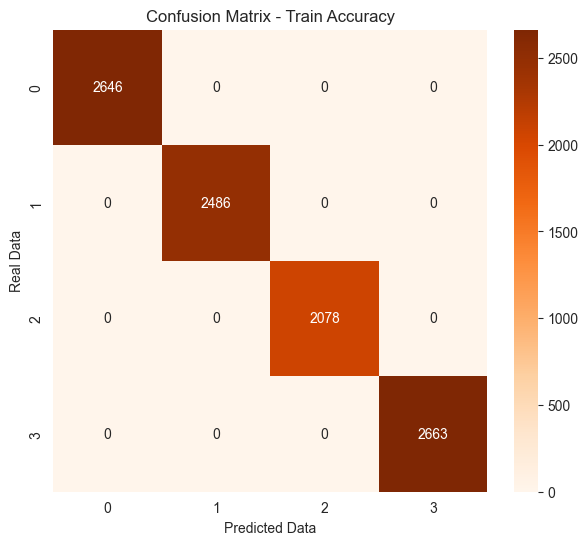

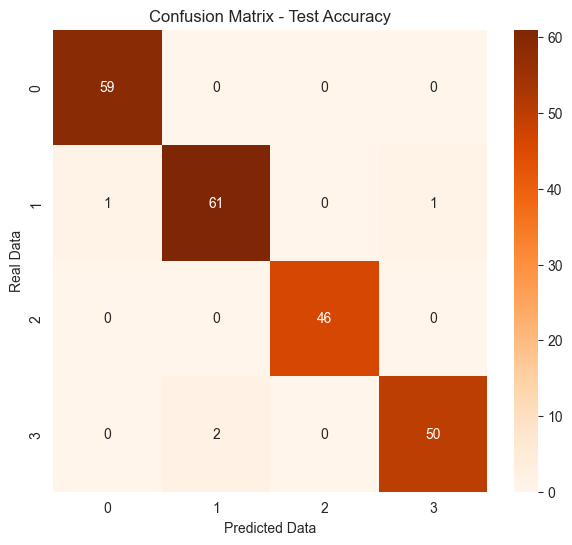

In [9]:
# Klasicke trenovanie
model2 = build_model(learning_rate=0.001, first_layer_neurons=128, second_layer_neurons=64, first_dropout_rate=0.0, second_dropout_rate=0.0)
history2 = model2.fit(X_train, Y_train, epochs=500, batch_size=16, validation_data=(X_val, Y_val), verbose=0)
loss2, accuracy2 = model2.evaluate(X_test, Y_test)

print("\nTreningova a validacna strata: ", loss2, "\nTreningova a validacna uspesnost: ", accuracy2)
generate_plots(history2)
generate_accuracy(model2)

In [10]:
# Parametre Early Stoppingu
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0575 - sparse_categorical_accuracy: 0.9809 

Treningova a validacna strata:  0.07007578015327454 
Treningova a validacna uspesnost:  0.9727272987365723


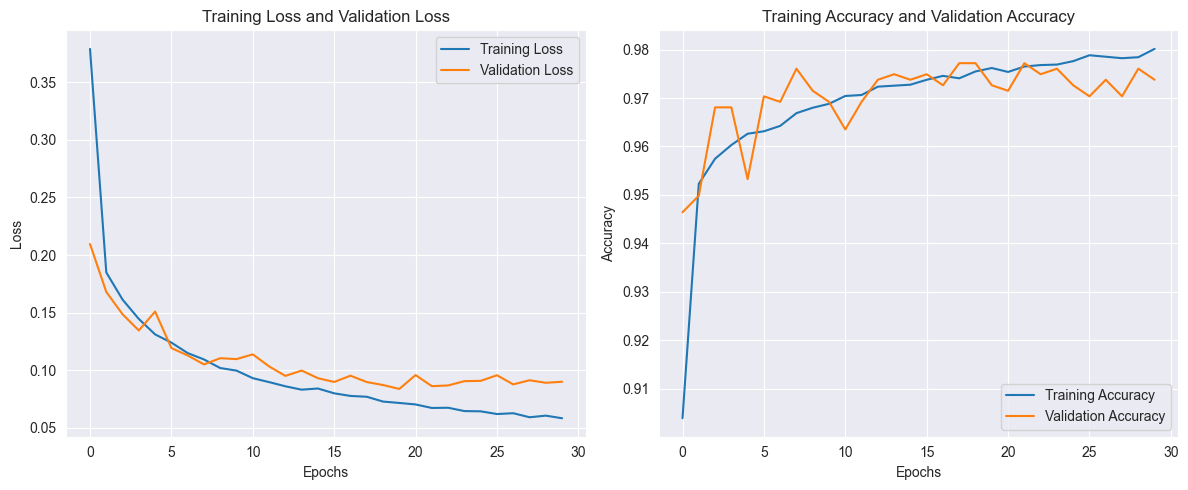

309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  

Trenovacia uspesnost: 0.9780208649853135
Testovacia uspesnost: 0.9727272727272728


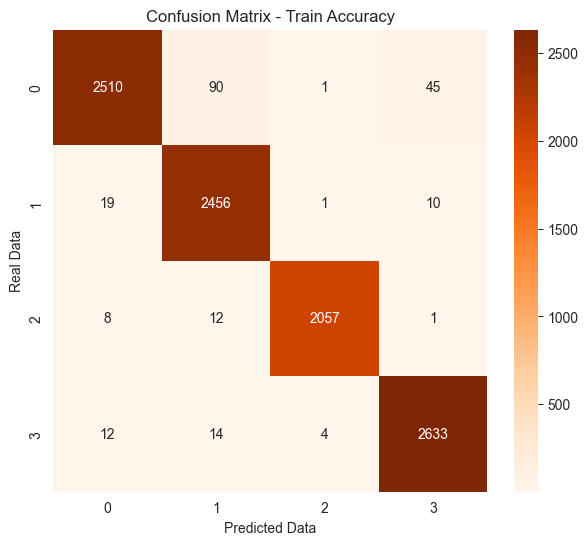

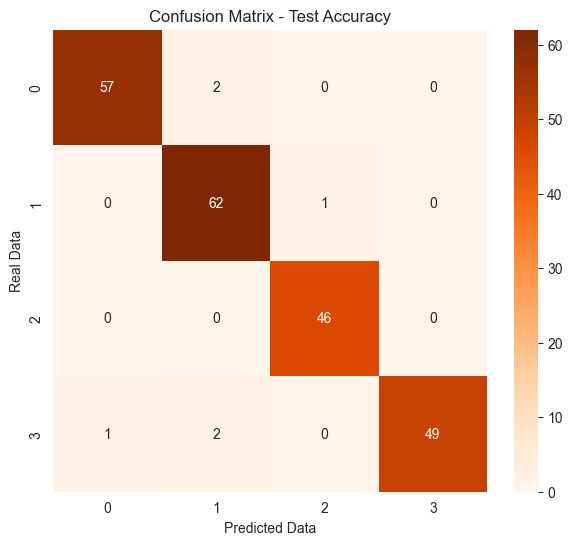

In [11]:
# Trenovanie v pouzitim Early Stopping
model3 = build_model(learning_rate=0.001, first_layer_neurons=128, second_layer_neurons=64, first_dropout_rate=0.0, second_dropout_rate=0.0)
history3 = model3.fit(X_train, Y_train, epochs=500, batch_size=16, validation_data=(X_val, Y_val), callbacks=[early_stopping], verbose=0)
loss3, accuracy3 = model3.evaluate(X_test, Y_test)

print("\nTreningova a validacna strata: ", loss3, "\nTreningova a validacna uspesnost: ", accuracy3)
generate_plots(history3)
generate_accuracy(model3)

E X P E R I M E N T Y

Experiment: Pandas(Index=0, learning_rate=0.001, first_layer_neurons=64, second_layer_neurons=32)


C:\Users\LukasPatrnciak\AppData\Local\Temp\ipykernel_19568\1020365217.py:53: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results2 = pd.concat([results2, new_row], ignore_index=True)


Experiment: Pandas(Index=1, learning_rate=0.0001, first_layer_neurons=64, second_layer_neurons=32)
Experiment: Pandas(Index=2, learning_rate=0.01, first_layer_neurons=64, second_layer_neurons=32)
Experiment: Pandas(Index=3, learning_rate=0.01, first_layer_neurons=128, second_layer_neurons=16)
Experiment: Pandas(Index=4, learning_rate=0.01, first_layer_neurons=32, second_layer_neurons=32)



V Y S L E D K Y

    learning_rate first_layer_neurons second_layer_neurons  train_acc  test_acc
0         0.0010                  64                   32   0.990682  0.968182
1         0.0001                  64                   32   0.978831  0.968182
2         0.0100                  64                   32   0.976096  0.959091
3         0.0100                 128                   16   0.981262  0.990909
4         0.0100                  32                   32   0.986022  0.977273 


N A J L E P S I   E X P .

Index: 3 
Priemernou uspesnost (trenovacia + testovacia / 2): 0.9860855638980865


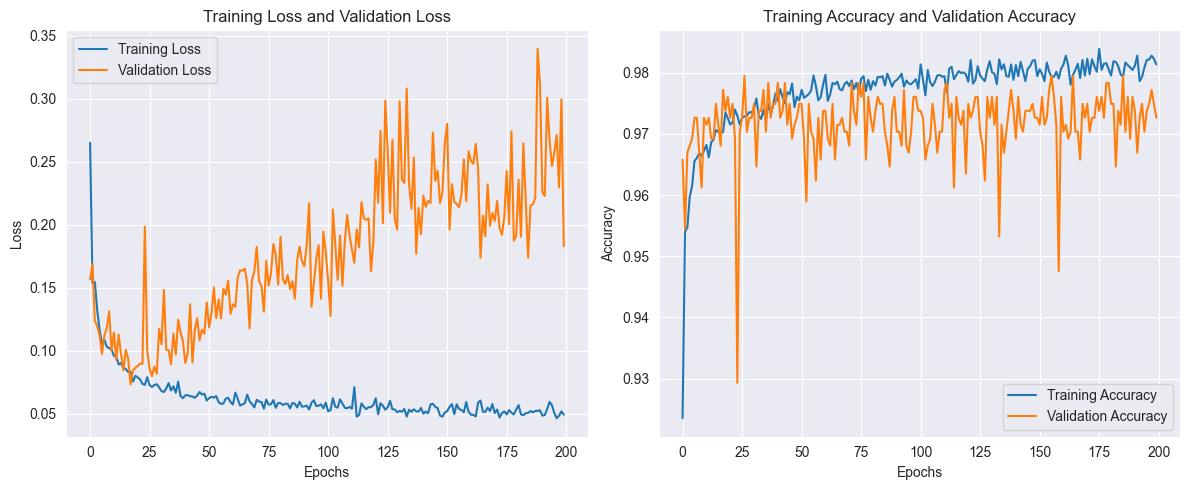

309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

Trenovacia uspesnost: 0.9812620277524562
Testovacia uspesnost: 0.990909090909091


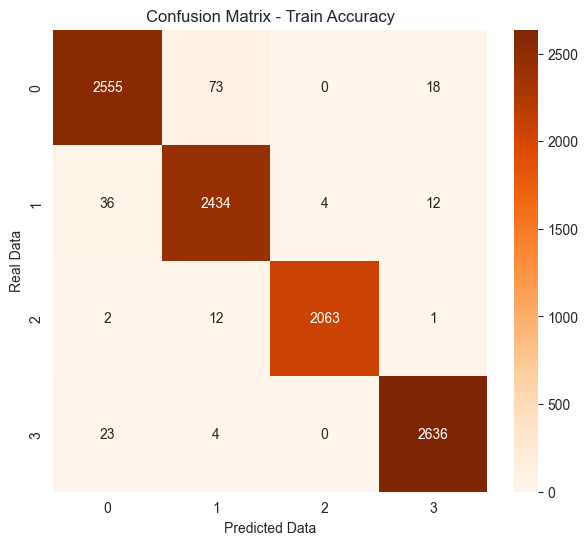

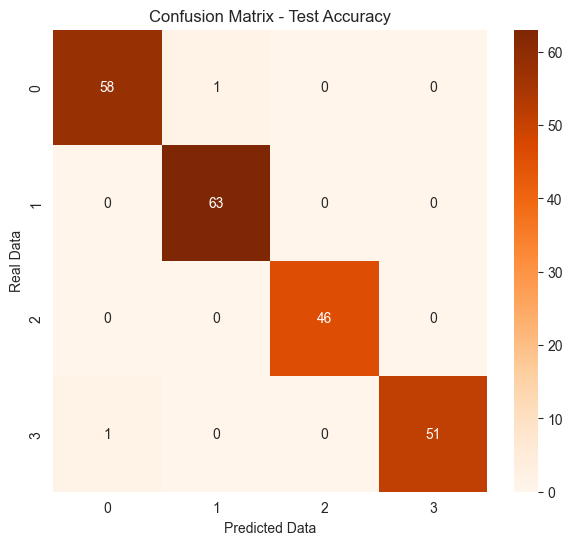




N A J H O R S I   E X P .

Index: 2 
Priemerna uspesnost (trenovacia + testovacia / 2): 0.9675936698913574


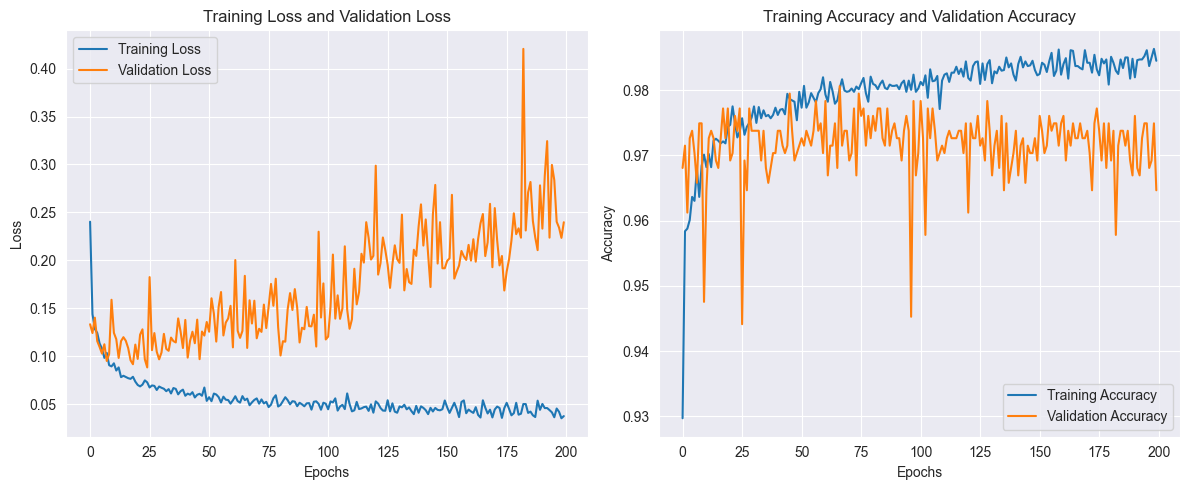

309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

Trenovacia uspesnost: 0.9760964245923225
Testovacia uspesnost: 0.9590909090909091


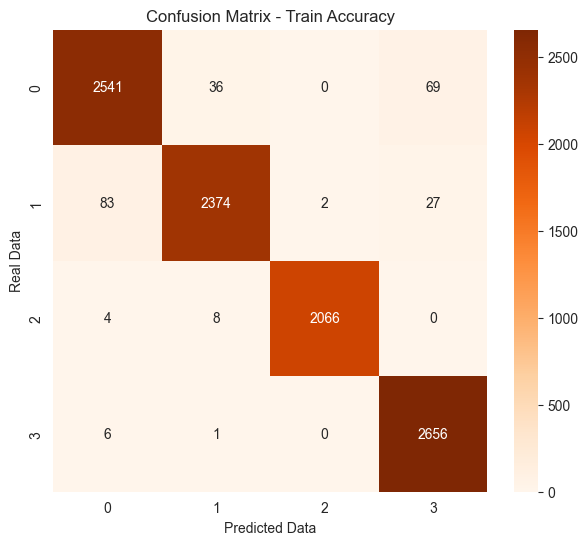

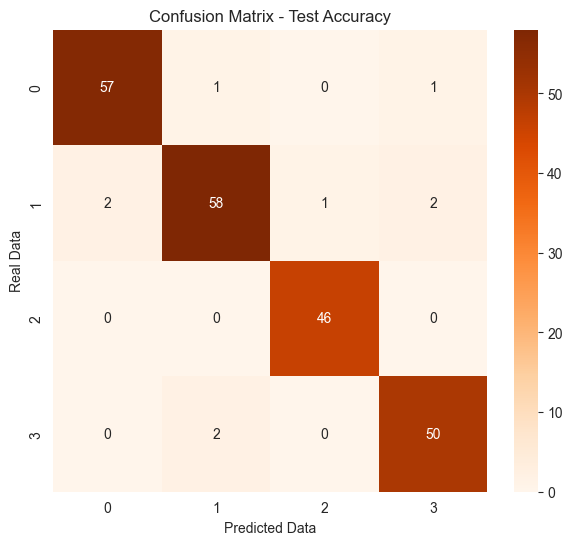

In [12]:
experiments2 = pd.DataFrame(columns=['learning_rate', 'first_layer_neurons', 'second_layer_neurons'])
experiments2['learning_rate'] = [0.001, 0.0001, 0.01, 0.01, 0.01]
experiments2['first_layer_neurons'] = [64, 64, 64, 128, 32]
experiments2['second_layer_neurons'] = [32, 32, 32, 16, 32]

results2 = pd.DataFrame(columns=['learning_rate', 'first_layer_neurons', 'second_layer_neurons', 'train_acc', 'test_acc'])
best_result = []
worst_result = []
best_acc = 0
worst_acc = 1

print("E X P E R I M E N T Y\n")

for exp2 in experiments2.itertuples():
    print(f"Experiment: {exp2}")
    model4 = build_model(learning_rate=exp2.learning_rate, 
                         first_layer_neurons=exp2.first_layer_neurons, 
                         second_layer_neurons=exp2.second_layer_neurons, 
                         first_dropout_rate=0.0, 
                         second_dropout_rate=0.0)
    
    history4 = model4.fit(X_train, Y_train, epochs=200, batch_size=16, validation_data=(X_val, Y_val), verbose=0)

    train_acc = model4.evaluate(X_train, Y_train, verbose=0)[1]
    test_acc = model4.evaluate(X_test, Y_test, verbose=0)[1]
    
    total_acc = (train_acc + test_acc)/2 
    
    if total_acc > best_acc:
        best_acc = total_acc
        best_result.clear()
        best_result.append(exp2.Index)
        best_result.append(best_acc)
        best_result.append(history4)
        best_result.append(model4)
        
    if total_acc < worst_acc:
        worst_acc = total_acc
        worst_result.clear()
        worst_result.append(exp2.Index)
        worst_result.append(worst_acc)
        worst_result.append(history4)
        worst_result.append(model4)
 
    new_row = pd.DataFrame({
        'learning_rate': [exp2.learning_rate],
        'first_layer_neurons': [exp2.first_layer_neurons],
        'second_layer_neurons': [exp2.second_layer_neurons],
        'train_acc': [train_acc],
        'test_acc': [test_acc]
    })

    results2 = pd.concat([results2, new_row], ignore_index=True)

print("\n\n\nV Y S L E D K Y\n\n", results2.head(), 
       "\n\n\nN A J L E P S I   E X P .\n\nIndex:", best_result[0], "\nPriemernou uspesnost (trenovacia + testovacia / 2):", best_result[1]) 
generate_plots(best_result[2]) 
generate_accuracy(best_result[3])

print("\n\n\nN A J H O R S I   E X P .\n\nIndex:", worst_result[0], "\nPriemerna uspesnost (trenovacia + testovacia / 2):", worst_result[1])
generate_plots(worst_result[2]) 
generate_accuracy(worst_result[3])

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0361 - sparse_categorical_accuracy: 0.9819 

Treningova a validacna strata:  0.05884567275643349 
Treningova a validacna uspesnost:  0.9727272987365723


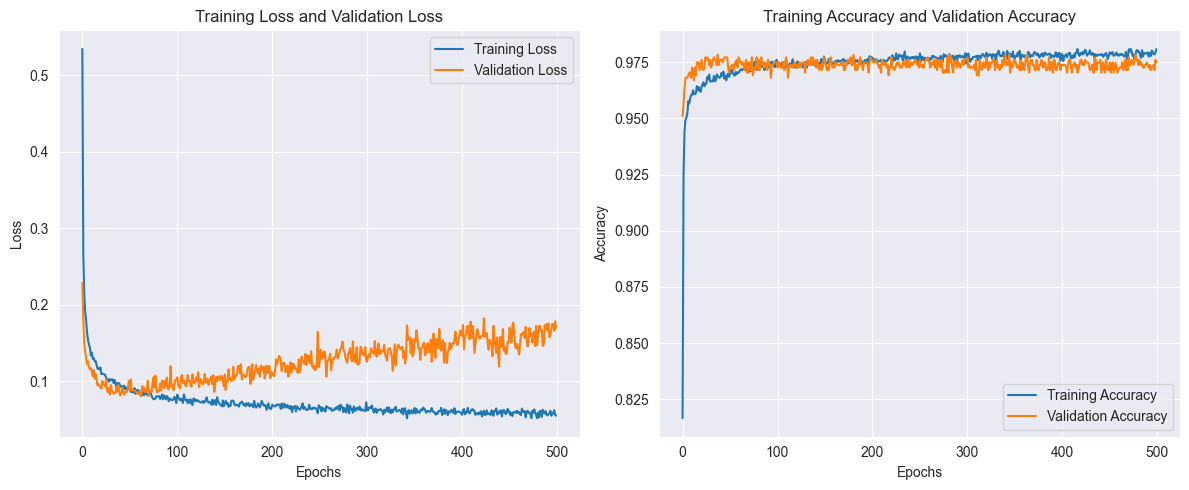

309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

Trenovacia uspesnost: 0.9895675073432594
Testovacia uspesnost: 0.9727272727272728


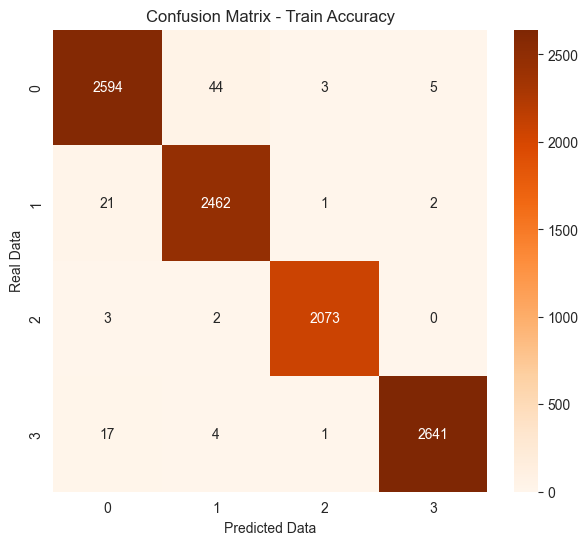

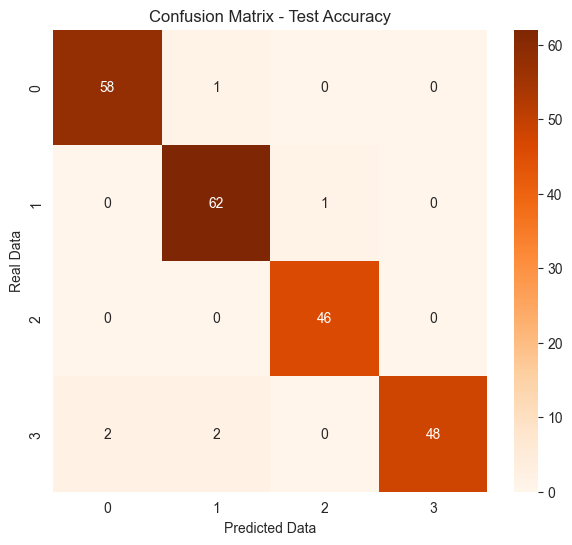

In [13]:
# Trenovanie s pouzitim Droupot s pravedepodobnostou pre 1. vrstvu 40% a pre druhu 40%
modelDropout = build_model(learning_rate=0.001, first_layer_neurons=128, second_layer_neurons=64, first_dropout_rate=0.4, second_dropout_rate=0.4)
historyDropout = modelDropout.fit(X_train, Y_train, epochs=500, batch_size=16, validation_data=(X_val, Y_val), verbose=0)
lossDropout, accuracyDropout = modelDropout.evaluate(X_test, Y_test)

print("\nTreningova a validacna strata: ", lossDropout, "\nTreningova a validacna uspesnost: ", accuracyDropout)
generate_plots(historyDropout)
generate_accuracy(modelDropout)